## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [1]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import importlib
import models_mae
import librosa
import librosa.display
import importlib

### Define utils

In [2]:
MELBINS=128
TARGET_LEN=1024
# INDO:
# norm_mean= -9.148823
# norm_std= 4.4092674

# CORAL CHORUS:
norm_mean= -9.894564
norm_std= 4.1962166

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=0)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def prepare_model1(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=1, decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):

    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    #plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

In [8]:
importlib.reload(models_mae)
#chkpt_dir = '/checkpoint/berniehuang/experiments/53417041/checkpoint-80.pth'
#chkpt_dir = '/checkpoint/berniehuang/experiments/55951690/checkpoint-20.pth' #(TF-mask AMAE, 0.7. 0.3)
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986074/checkpoint-20.pth' #(TF-mask AMAE) (0.5, 0.2)
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986075/checkpoint-20.pth' #(TF-mask AMAE) (0.2, 0.1)
#chkpt_dir = '/checkpoint/berniehuang/experiments/54463265/checkpoint-28.pth' # random AMAE
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986072/checkpoint-32.pth' # random AMAE (new)
#chkpt_dir = '/checkpoint/berniehuang/experiments/56067384/checkpoint-28.pth' # random AMAE (new)
#chkpt_dir = '/checkpoint/berniehuang/experiments/56373517/checkpoint-24.pth' # random AMAE, decoder=4, norm_pxl=False
# chkpt_dir = '/checkpoint/berniehuang/experiments/56538025/checkpoint-24.pth' # random AMAES, decoder=4, norm_pxl=False
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_indo_mask0.8/checkpoint-32.pth'
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_coral_chorus_mask0.8/checkpoint-20.pth'
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/AS_2M/pretrained.pth'
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_australia/checkpoint-32.pth'
chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_australia_large/checkpoint-32.pth'
model = prepare_model1(chkpt_dir, 'mae_vit_large_patch16')
#model = prepare_model1(chkpt_dir, 'mae_vit_base_patch16')
#model = prepare_model(chkpt_dir, 'amvmae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def run_one_audio(wav_file, model):
    fbank = wav2fbank(wav_file)
    fbank = norm_fbank(fbank)
    x = torch.tensor(fbank)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    mask_ratio = 0.8
    _, y, mask, _ = model(x.float(), mask_ratio=mask_ratio)
    y_unpatch = model.unpatchify(y)
    y_unpatch = torch.einsum('nchw->nhwc', y_unpatch).detach().cpu()
    # visualize the mask
    mask = mask.detach()
    #mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    #print(x.shape, mask.shape)
    # masked image
    x = torch.einsum('nchw->nhwc', x)
    im_masked = x * (1 - mask)

    minmin=-5
    maxmax=10
    start=150
    end=800
    
    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 12]

    plt.subplot(3, 1, 1)
    display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)
    #plt.show()

    plt.subplot(3, 1, 2)
    display_fbank(im_masked[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)
    #plt.show()
    
    plt.subplot(3, 1, 3)
    display_fbank((y_unpatch[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)
    #plt.show()
    
    if model.mask_2d:
        fn=os.path.basename(wav_file).replace('.wav',f'_2d_{model.mask_t_prob}_{model.mask_f_prob}.pdf')
    else:
        fn=os.path.basename(wav_file).replace('.wav',f'_{mask_ratio}.pdf')
    fn=os.path.join('/mnt/data/tungtran/AudioMAE/plots',fn)
    plt.savefig(fn)

In [22]:
wav_file0 = '/mnt/data/tungtran/data/coral_chorus/Cocoloba_rawaudio_split/1678000154.170726000036_chunk_3.wav'
wav_file0 = '/mnt/data/tungtran/data/coral_chorus/OffReef_rawaudio_split/1677996071.170727134926_chunk_2.wav'
wav_file1= '/mnt/data/tungtran/data/indonesia_hour_long_split/BaF1.1055H.1678278701.180827_chunk_3.wav'
wav_file2 = '__3b1YjrJAI_30.0-40.0.mp3.mp3'
wav_file3 = '/mnt/data/tungtran/AudioMAE/plots/SiteKdeployment2.1678278701.181101224813_chunk_6.wav'

/tmp/ipykernel_2515630/3183881074.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


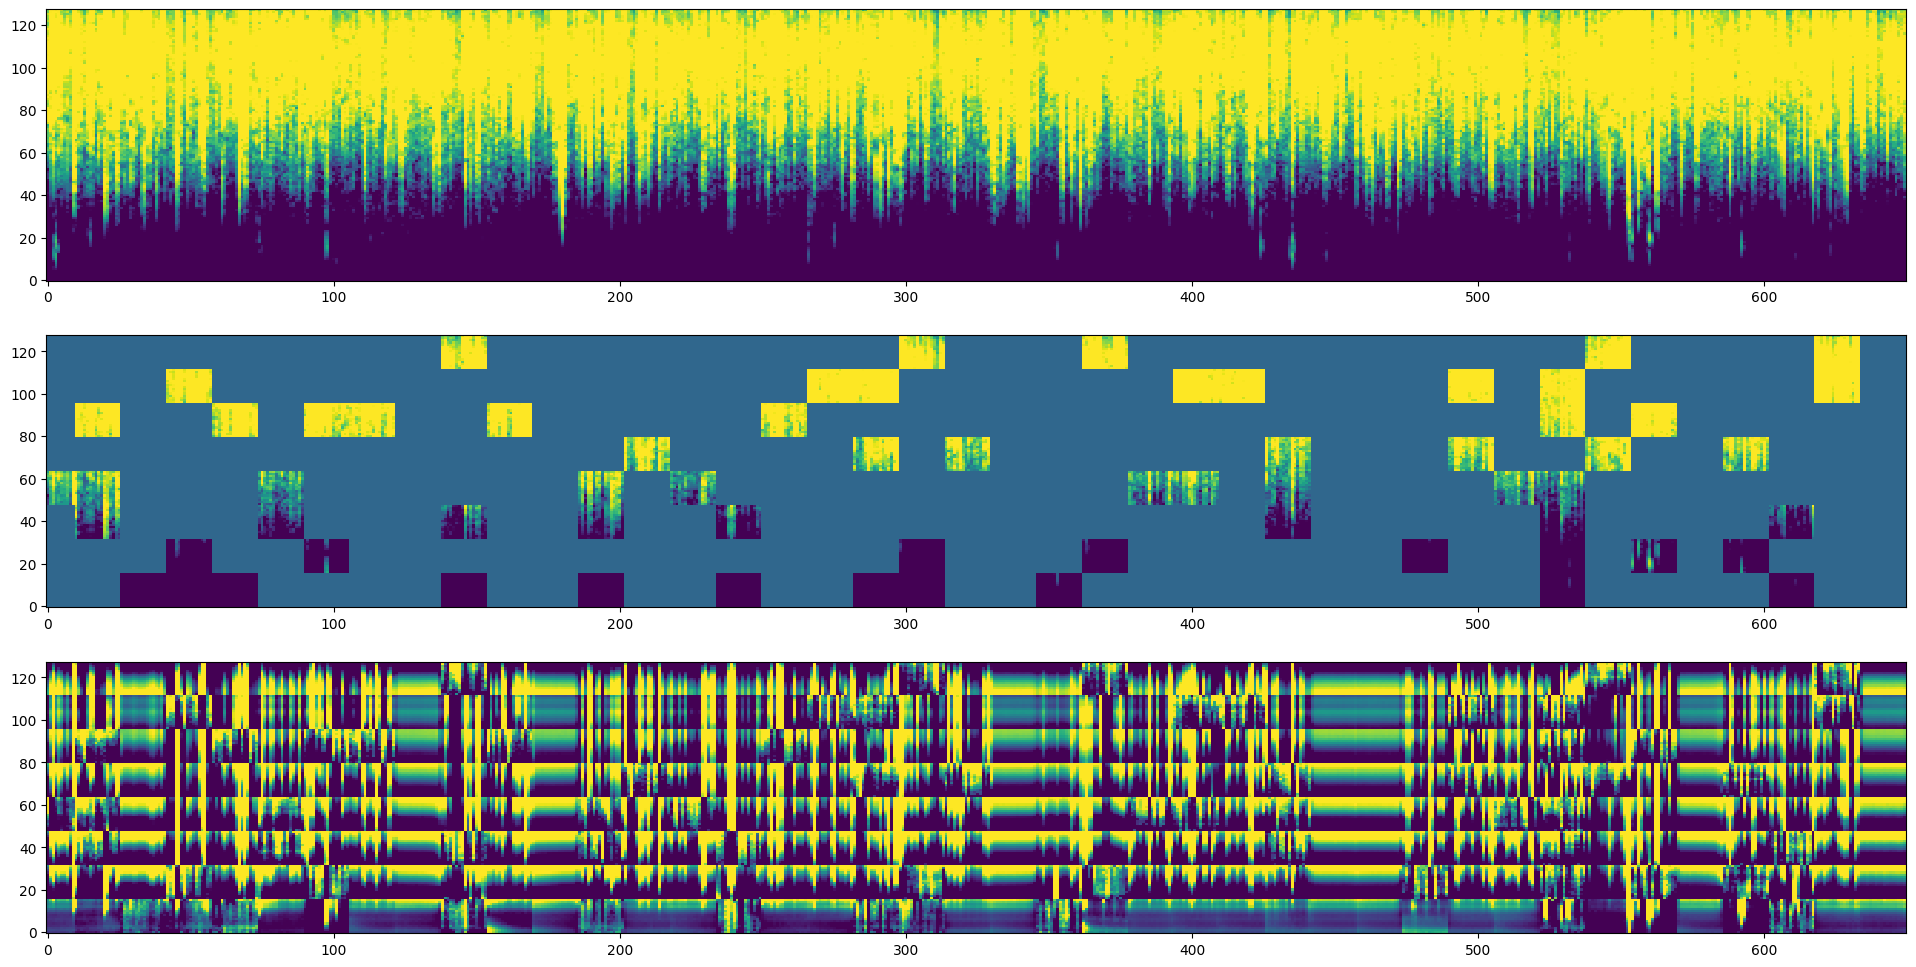

In [23]:
torch.manual_seed(32)
model.mask_2d=False
model.mask_t_prob=0.1
model.mask_f_prob=0.1
run_one_audio(wav_file3, model)